In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import cleantext
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['us', 'aa', 'told', 'said', 'get', 'never', 'american', 'delta', 'southwest', 'south', 'west', 'would', 
                   'next', 'even', 'one', 'back', 'first', 'like', 'could', 'great', 'good', 'bad', 'worst', 'ever',
                   'airlines', 'airline', 'flight', 'fly', 'flights', 'flying', 'way', 'also', 'got', 'made', 'airport',
                   'go', 'people', 'call', 'home', 'day', 'asked', 'son', 'two', 'three', 'four', 'five', 'make', 'slc',
                   'many', 'nice', 'love', 'another', 'area', 'always', 'well', 'easy', 'best', 'went', 'much', 'use',
                   'going', 'really', 'know', 'since', 'knowing', 'knows', 'knew', 'little', 'give', 'again', "don't"])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#Pos Before
df = pd.read_csv('/Path/to_topicmodel/pos_before.csv', error_bad_lines=False);
clean_reviews = df.drop(columns=['compound', 'Date', 'Date.1', 'Rating', 'Title', 'scores', 'compound.1'], axis=1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.Review])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.Review])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

reviews_w_ngrams = clean_reviews.copy()
reviews_w_ngrams.Review = reviews_w_ngrams.Review.map(lambda x: replace_ngram(x))
reviews_w_ngrams = reviews_w_ngrams.Review.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_words and len(word) > 2])
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
dictionary = corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20


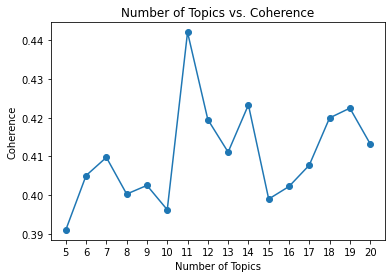

In [6]:

coherence = []
for k in range(5,21):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()


In [7]:
#Try 11 and 14
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=11, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

ldamodel.show_topics(11, num_words=15, formatted=False)
pprint(ldamodel.print_topics())

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"time" + 0.009*"helpful." + 0.007*"service" + 0.007*"trip" + '
  '0.006*"food" + 0.005*"came" + 0.005*"time," + 0.005*"staff" + 0.005*"plane" '
  '+ 0.004*"gate"'),
 (1,
  '0.018*"time" + 0.015*"time." + 0.014*"check" + 0.007*"checked" + '
  '0.006*"line" + 0.006*"take" + 0.006*"staff" + 0.006*"service." + '
  '0.005*"experience" + 0.005*"service"'),
 (2,
  '0.010*"time" + 0.007*"flight." + 0.006*"seat" + 0.006*"arrived" + '
  '0.005*"food" + 0.005*"took" + 0.005*"travel" + 0.005*"good," + '
  '0.005*"amazing" + 0.004*"baggage"'),
 (3,
  '0.014*"staff" + 0.012*"check" + 0.011*"time" + 0.010*"trip" + '
  '0.007*"service" + 0.006*"food" + 0.006*"flight." + 0.006*"travel" + '
  '0.006*"crew" + 0.005*"boarding"'),
 (4,
  '0.021*"time" + 0.013*"service" + 0.012*"seat" + 0.010*"flight." + '
  '0.008*"plane" + 0.008*"class" + 0.008*"staff" + 0.008*"entertainment" + '
  '0.007*"economy" + 0.007*"boarding"'),
 (5,
  '0.015*"time" + 0.013*"flight." + 0.009*"service" + 0.009*"check"

In [8]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=14, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

ldamodel2.show_topics(14, num_words=15, formatted=False)
pprint(ldamodel2.print_topics())

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.016*"flight." + 0.015*"time" + 0.010*"plane" + 0.009*"service" + '
  '0.008*"luggage" + 0.006*"seat" + 0.005*"check" + 0.005*"arrived" + '
  '0.005*"stop" + 0.004*"staff"'),
 (1,
  '0.018*"time" + 0.010*"staff" + 0.010*"flight." + 0.008*"security" + '
  '0.005*"took" + 0.005*"waiting" + 0.004*"plane" + 0.004*"check" + '
  '0.004*"arrived" + 0.004*"crew"'),
 (2,
  '0.015*"trip" + 0.006*"paid" + 0.006*"gate" + 0.006*"seat" + '
  '0.006*"experience" + 0.006*"flight." + 0.005*"entertainment" + '
  '0.005*"check" + 0.005*"staff" + 0.004*"service"'),
 (3,
  '0.018*"time" + 0.015*"seat" + 0.014*"staff" + 0.013*"check" + 0.013*"plane" '
  '+ 0.010*"boarding" + 0.006*"crew" + 0.005*"luggage" + 0.005*"took" + '
  '0.005*"everyone"'),
 (4,
  '0.013*"time." + 0.012*"flight." + 0.010*"experience" + 0.009*"staff" + '
  '0.008*"helpful." + 0.007*"check" + 0.007*"plane" + 0.006*"time" + '
  '0.006*"service." + 0.006*"service"'),
 (5,
  '0.016*"service" + 0.015*"staff" + 0.007*"time" + 0.007*

In [8]:
topic_data =  pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
